In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
import time
from pennylane.optimize import AdamOptimizer
import torch

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [11, 7]
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

In [2]:
num_dim = 1
num_discrete_values = 16
num_qubits = 1 * int(np.log2(num_discrete_values))

In [3]:
from scipy.stats import multivariate_normal

coords = np.arange(0, 16)
rv = multivariate_normal(mean=[7.0], cov=[[1.5]])
grid_elements = coords
prob_data = rv.pdf(grid_elements)
prob_data = prob_data / np.sum(prob_data)

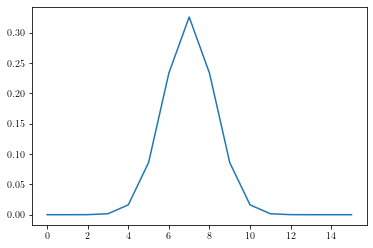

In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm

mesh_x, mesh_y = np.meshgrid(coords, coords)
grid_shape = (num_discrete_values, num_discrete_values)

plt.plot(coords,prob_data)
plt.show()

In [5]:
dev = qml.device("default.qubit.torch", wires=num_qubits)

@qml.qnode(dev, interface="torch", diff_method="backprop")
def circuit(inputs, weights):
    for wire in range(num_qubits): qml.Hadamard(wires=wire)
    qml.StronglyEntanglingLayers(weights=weights, wires=list(range(num_qubits)))
    return qml.probs()

In [6]:
n_layers=8
weight_shapes = {"weights": (n_layers, num_qubits,3)}

In [7]:
qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)

In [8]:
from torch import nn


class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        self.linear_input = nn.Linear(input_size, 20)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear20 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.linear_input(input)
        x = self.leaky_relu(x)
        x = self.linear20(x)
        x = self.sigmoid(x)
        return x

In [9]:
generator = qlayer
discriminator = Discriminator(num_dim)

In [10]:
def adversarial_loss(input, target, w):
    bce_loss = target * torch.log(input) + (1 - target) * torch.log(1 - input)
    weighted_loss = w * bce_loss
    total_loss = -torch.sum(weighted_loss)
    return total_loss

In [11]:
from torch.optim import Adam

lr = 0.0001  # learning rate
#b1 = 0.7  # first momentum parameter
b1 = 0.6  # first momentum parameter
b2 = 0.999  # second momentum parameter

generator_optimizer = Adam(generator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0, amsgrad=True)
discriminator_optimizer = Adam(
    discriminator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0, amsgrad=True
)

decayRate = 0.9997
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=decayRate)

In [12]:
from IPython.display import clear_output

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

def plot_training_progress(n):
    # we don't plot if we don't have enough data
    if len(generator_loss_values) < 2:
        return

    clear_output(wait=True)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 9))
    fig.tight_layout(pad=5.0)

    # Generator Loss
    ax3.plot(generator_loss_values, label="generator loss", color="royalblue")
    ax3.plot(discriminator_loss_values, label="discriminator loss", color="magenta")
    ax3.legend(loc="best", fontsize=16)
    ax3.set_xlabel("epoch", fontsize=16)
    ax3.set_ylabel("Loss", fontsize=16)
    #ax3.grid()

    # Relative Entropy
    ax2.plot(entropy_values)
    ax2.set_xlabel("epoch", fontsize=18)
    ax2.set_ylabel("KL divergence", fontsize=18)
    ax2.set_yscale("log")
    #ax2.grid()
    
    paramsg = generator.weights
    generated_probabilities = circuit(1,paramsg).detach()
    ax1.plot(generated_probabilities, label="generated")
    ax1.plot(prob_data,label="real")
    ax1.legend(loc="upper right", fontsize=18)
    ax1.set_xlabel("$i$", fontsize=18)
    ax1.set_ylabel("$P_i$", fontsize=18)
    #ax3.grid()
    #plt.savefig(f"imgs/plt-{n}.png")

    plt.show()

In [19]:
import time
from scipy.stats import multivariate_normal, entropy

n_epochs = 20000

torch.nn.init.uniform_(list(generator.parameters())[0], a=-0.1, b=0.1)

num_qnn_outputs = num_discrete_values**num_dim

generator_loss_values = []
discriminator_loss_values = []
entropy_values = []

start = time.time()
for epoch in range(n_epochs):

    valid = torch.ones(num_qnn_outputs, dtype=torch.float)
    fake = torch.zeros(num_qnn_outputs, dtype=torch.float)

    # Configure input
    real_dist = torch.tensor(prob_data, dtype=torch.float).reshape(-1, 1)

    # Configure samples
    #samples = torch.tensor(grid_elements.reshape(grid_elements.shape[-1],1), dtype=torch.float)
    samples = torch.tensor(np.random.randint(0,16, size=(16,)), dtype=torch.float).reshape(16,1)
    
    disc_value = discriminator(samples)

    # Generate data
    gen_dist = generator(torch.tensor([])).reshape(-1, 1)

    # Train generator
    generator_optimizer.zero_grad()
    generator_loss = adversarial_loss(disc_value, valid, gen_dist[samples.long().reshape(-1)])

    # store for plotting
    generator_loss_values.append(generator_loss.detach().item())

    generator_loss.backward(retain_graph=True)
    generator_optimizer.step()

    # Train Discriminator
    discriminator_optimizer.zero_grad()
    
    #print(gen_dist.shape)
    #print(samples.reshape(-1))
    #print(gen_dist[samples.long().reshape(-1)].shape)

    real_loss = adversarial_loss(disc_value, valid, real_dist[samples.long().reshape(-1)].reshape(-1,1))
    fake_loss = adversarial_loss(disc_value, fake, gen_dist.detach()[samples.long().reshape(-1)])
    discriminator_loss = (real_loss + fake_loss) / 2

    # Store for plotting
    discriminator_loss_values.append(discriminator_loss.detach().item())

    discriminator_loss.backward()
    discriminator_optimizer.step()

    entropy_value = entropy(gen_dist.detach().squeeze().numpy(), prob_data)
    entropy_values.append(entropy_value)

    my_lr_scheduler.step()
    
    plot_training_progress(epoch)
    #break

elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} sec")


KeyboardInterrupt



In [ ]:
paramsg = generator.weights
generated_probabilities = circuit(1,paramsg).detach()

In [ ]:
plt.plot(generated_probabilities)